## Кратко о проекте:

### Задача:
<br>Совместно с отделом маркетинга необходимо проверить гипотезы для увеличения выручки. 
<br>
<br>Для выполнения работы необходимо:
    <br>    - провести приоретизацию гипотез;
    <br>    - проанализировать результаты А/В-теста.
    
### Описание данных:
Файл /datasets/hypothesis.csv
 - Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv
 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv
 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста.


## Загрузка и подготовка данных

In [1]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# загружаем файлы с данными
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# устанавливает максимальную ширину столбца, что бы видеть все содержимое
pd.set_option('max_colwidth', 120) 

# проверим первичную информацию о данных с помощью цикла
df_list = [hypothesis, orders, visitors]

for df in df_list:
    display(df.head())
    display(df.info())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

После первого просмотра нужно кое что исправить для удобства работы:
 - в таблице "hypothesis" приведем имена столбцов к нижнему регистру;
 - привести даты к верному типу данных.

In [4]:
# приведем название столбцов к нижнему регистру
hypothesis.columns = map(str.lower, hypothesis.columns)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# приведем даты к нужному типу данных и к нужному формату
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
    
# проверим все ли получилось
display(orders.info())
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

In [6]:
# проверяем данные на пустые значения
for df in df_list:
    display(df.isna().sum())

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

In [7]:
# ищем дубликаты
for df in df_list:
    display(df.duplicated().sum())

0

0

0

### Вывод:
Данные чистые, в большой предообработке необходимости нет.

In [8]:
display(orders['group'].unique())

array(['B', 'A'], dtype=object)

In [9]:
display(visitors['group'].unique())

array(['A', 'B'], dtype=object)

In [10]:
# максимальная и минимальная дата заказов
display(orders['date'].min())
display(orders['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

In [11]:
# максимальная и минимальная дата посещений
display(visitors['date'].min())
display(visitors['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

# Часть 1. Приоритизация гипотез

## Что необходимо сделать в этой части:
 - установить приоритет с помощью фреймворка ICE, отсортировать их по убыванию приоритета;
 - установить приоритет с помощью фреймворка RICE, отсортировать их по убыванию приоритета;
 - проанализировать полученные результаты.

### Установка приоритетов с фреймворком ICE

In [12]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False).round(0))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


### Установка приоритетов с фреймворком RICE

In [13]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Анализ полученных результатов

In [14]:
# посмотрим все вместе
display(hypothesis[['hypothesis', 'ICE', 'RICE']].round(0))

,hypothesis,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0,16.0


### Подведем итоги этой части:
<b>Приоритет по фреймворку ICE</b>
<br>В результате расчета самыми перспективными гипотезами стали:
 - Запустить акцию, дающую скидку на товар в день рождения;
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

<b>Приоритет по фреймворку RICE</b>
<br>В результате расчета самыми перспективными гипотезами стали:
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

<b>Вывод:</b>
<br>В ходе установки приоритетов с помощью фреймворков ICE и RICE мы установили пару гипотез, которые необходимо проверить в ходе A/B-тестов:
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

# Часть 2. Анализ A/B-теста

## Что необходимо сделать в этой части:
В файлах "orders.csv" и "visitors.csv" находятся результаты A/B-тестов, которые необходимо проанализировать и сделать требуемые выводы.

### 1. Построить график кумулятивной выручки по группам.

In [16]:
datesGroups = orders[['date', 'group']].drop_duplicates()

In [17]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])].agg({
    'date': 'max',
    'group': 'max',
    'transactionId': pd.Series.nunique,
    'visitorId': pd.Series.nunique,
    'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

In [18]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])].agg({
    'date': 'max',
    'group': 'max',
    'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

In [19]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


In [20]:
display(cumulativeData['date'].min())
display(cumulativeData['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

In [21]:
# получим переменные с данными разбитыми на группы "А" и "В"
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

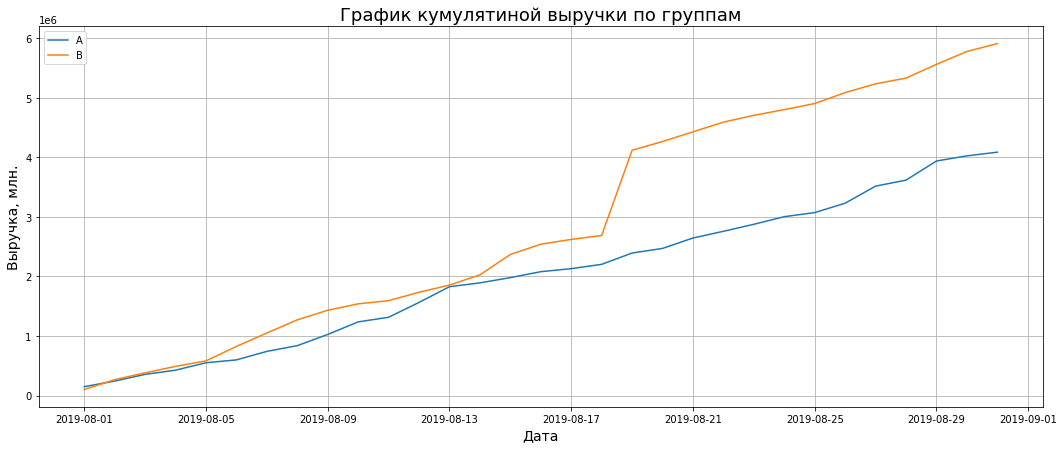

In [22]:
plt.figure(figsize=(18, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятиной выручки по группам', size=18)
plt.legend(loc='best')
plt.xlabel('Дата', size=14)
plt.ylabel('Выручка, млн.', size=14)
plt.grid()
plt.show()

Выручка равномерно увеличивается в обоих группах, но в группе В наблюдается резкий скачек, скорее всего это связано с заказами на большую сумму.

### 2. Построить график кумулятивного среднего чека по группам.

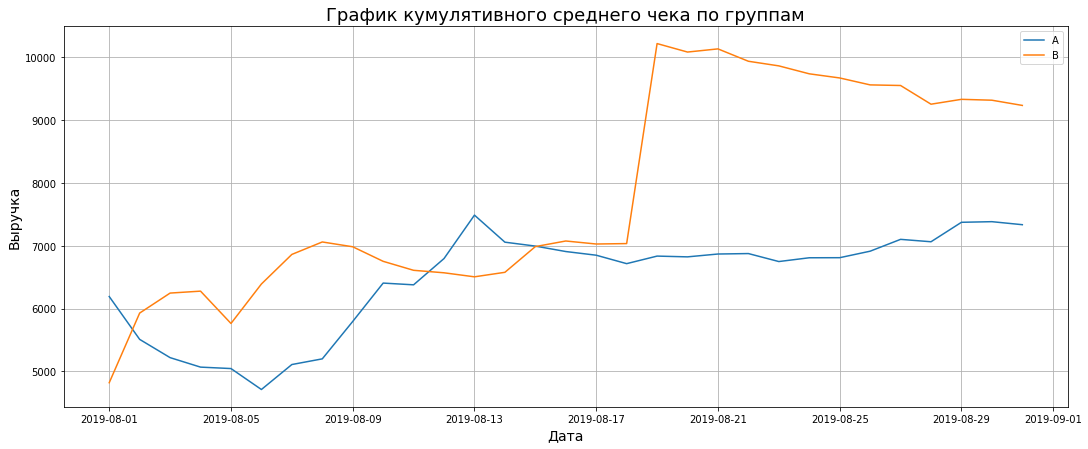

In [23]:
plt.figure(figsize=(18, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам', size=18)
plt.legend(loc='best')
plt.xlabel('Дата', size=14)
plt.ylabel('Выручка', size=14)
plt.grid()
plt.show()

Ситуация аналогичная прошлому графику: резкий скачек в группе В. 

### 3. Построить график относительного изменения кумулятивного среднего чека группы B к группе A.

In [24]:
# получим данные для графика
mergeCumRev = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

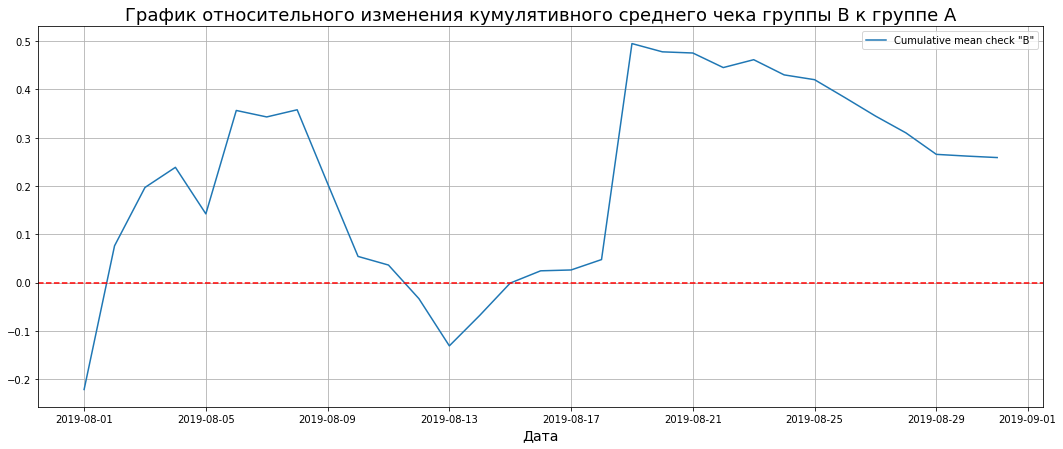

In [25]:
plt.figure(figsize=(18, 7))
plt.plot(mergeCumRev['date'], (mergeCumRev['revenueB']/mergeCumRev['ordersB'])/
         (mergeCumRev['revenueA']/mergeCumRev['ordersA'])-1, label='Cumulative mean check "B"')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=18)
plt.legend(loc='best')
plt.xlabel('Дата', size=14)
plt.axhline(y=0, color='red', linestyle='--')
plt.grid()
plt.show()

### 4. Построить график кумулятивной конверсии по группам.

In [26]:
# создадим новый столбец со значениями конверсии
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [27]:
# узнаем минимальную и максимальную дату
display(cumulativeData['date'].min())
display(cumulativeData['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

In [28]:
# создаем срезы по группам
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

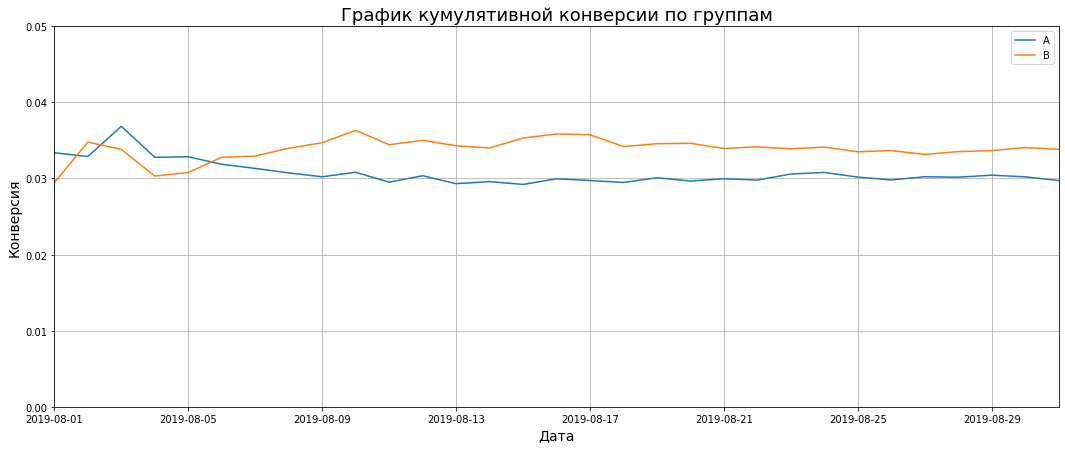

In [29]:
plt.figure(figsize=(18, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])
plt.title('График кумулятивной конверсии по группам', size=18)
plt.legend(loc='best')
plt.xlabel('Дата', size=14)
plt.ylabel('Конверсия', size=14)
plt.grid()
plt.show()

6.08.2019 группа В обходит группу А по значению среднего чека, 10.08.2019 значение фиксируется на отметке ~0.35

### 5. Построить график относительного изменения кумулятивной конверсии группы B к группе A.

In [30]:
mergeCumConv = cumulativeDataA[['date', 'conversion']].merge(
    cumulativeDataB[['date', 'conversion']],
    left_on = 'date',
    right_on = 'date',
    how = 'left',
    suffixes = ['A', 'B'])

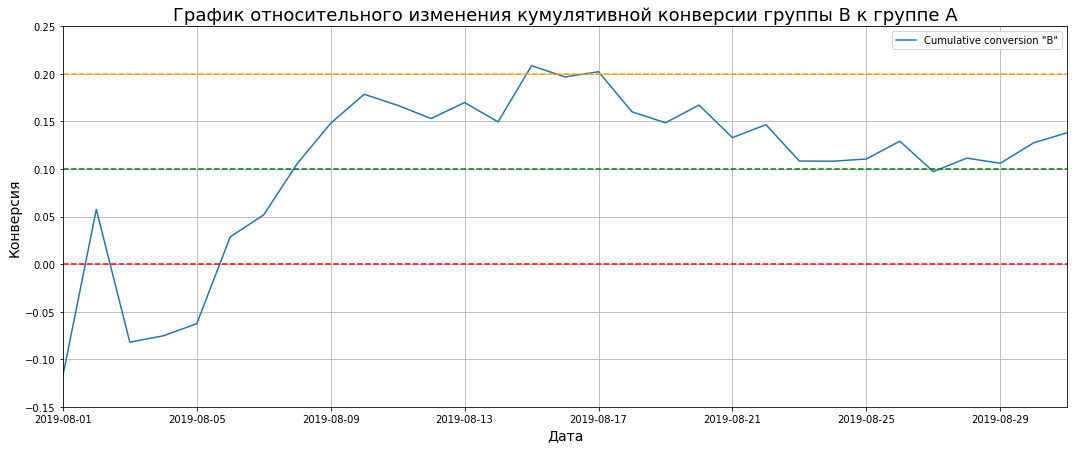

In [52]:
plt.figure(figsize=(18, 7))
plt.plot(mergeCumConv['date'], mergeCumConv['conversionB']/mergeCumConv['conversionA']-1, label='Cumulative conversion "B"')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.15, 0.25])
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', size=18)
plt.legend(loc='best')
plt.xlabel('Дата', size=14)
plt.ylabel('Конверсия', size=14)
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.1, color='green', linestyle='--')
plt.axhline(y=0.2, color='orange', linestyle='--')
plt.grid()
plt.show()

На данном графике наблюдается пик конверсии на отметке 20%, после данного пика значение конверсии уменьшается и фиксируется в диапазоне значений от 10% до 15%. 

### 6. Построить точечный график количества заказов по пользователям.

In [32]:
# сделаем новую таблицу содержащую информацию о заказах пользователей без групп, дат и дохода
ordersByUsers = (
    orders.drop(['group', 'date', 'revenue'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'}))

ordersByUsers.head()

,visitorId,transactionId
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


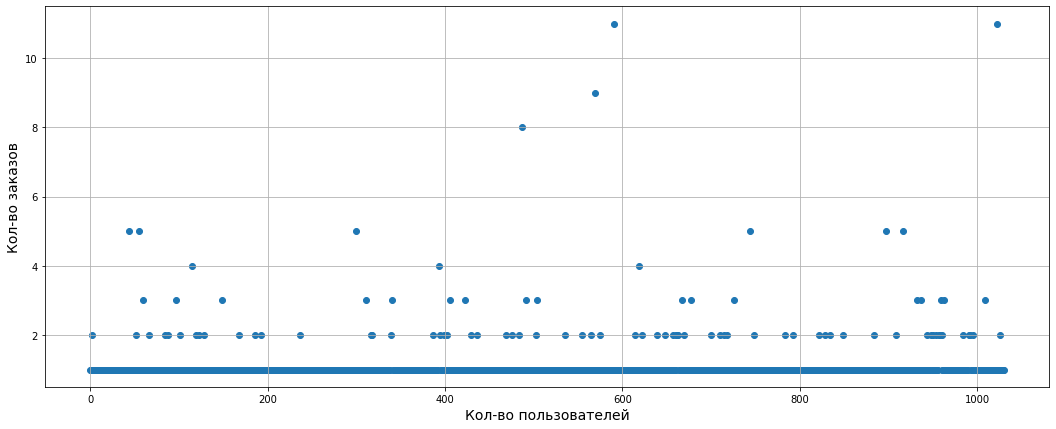

In [33]:
# построим график количества заказов
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(18, 7))
plt.scatter(x_values, ordersByUsers['transactionId'])
plt.xlabel('Кол-во пользователей', size=14)
plt.ylabel('Кол-во заказов', size=14)
plt.grid()
plt.show()

На графике видно, что пользователи предпочитают делать по 1-2 заказа. Случаи превышающие эту отметку являются единичными, их вполне можно причислить к аномальным.

### 7. Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.

In [34]:
np.percentile(ordersByUsers['transactionId'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали более 2 заказов.
<br>Не более 1% пользователей совершали более 4 заказов.

### 8. Построить точечный график стоимостей заказов.

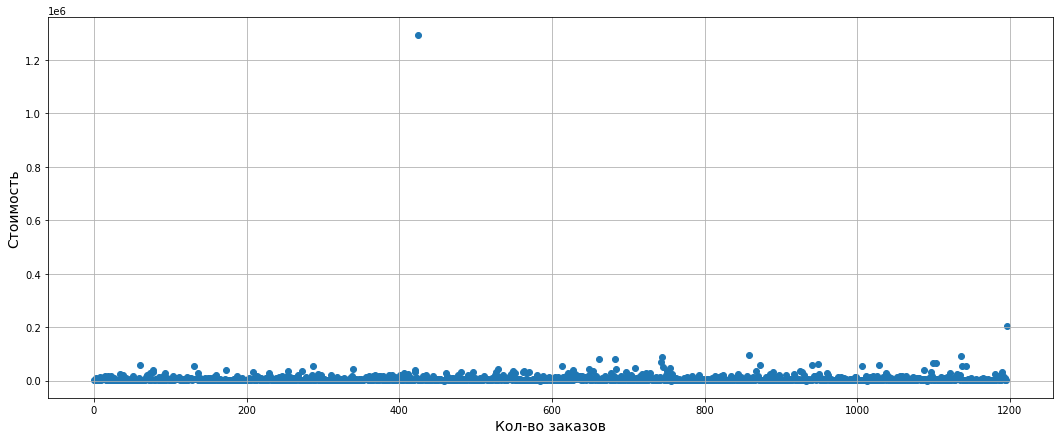

In [35]:
# построим график стоимости заказов
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(18, 7))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Кол-во заказов', size=14)
plt.ylabel('Стоимость', size=14)
plt.grid()
plt.show()

Основная масса заказов сгруппирована на отметке менее 50 тыс. Перцентили дадут более точную информацию.

### 9. Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.

In [36]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов превышают стоимость 28000.
<br>Не более 1% заказов превышает стоимость 58233.

### 10. Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным.

<b>Для начала необходимо сформулировать гипотезы:</b>
 - Н0 - статистически значимых различий в конверсии нет.
 - Н1 - статистически значимые различия в конверсии есть.

In [37]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [38]:
# посмотрим все ли получилось
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


<b>Значения столбцов в таблице:</b>
 - date — дата;
 - ordersPerDateA — количество заказов в выбранную дату в группе A;
 - revenuePerDateA — суммарная выручка в выбранную дату в группе A;
 - ordersPerDateB — количество заказов в выбранную дату в группе B;
 - revenuePerDateB — суммарная выручка в выбранную дату в группе B;
 - ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
 - revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
 - ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
 - revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
 - visitorsPerDateA — количество пользователей в выбранную дату в группе A;
 - visitorsPerDateB — количество пользователей в выбранную дату в группе B;
 - visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
 - visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [39]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [40]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')


sampleA = pd.concat(
    [ordersByUsersA['orders'], 
     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'], 
     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

In [41]:
sampleA = pd.concat(
    [ordersByUsersA['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],
    axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders')], 
    axis=0)

In [42]:
display("P-value: {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

display("Конверсия: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

'P-value: 0.01679'

'Конверсия: 0.138'

Р-value меньше 5%, нулевую гипотезу следует отвергнуть. Анализ "сырых" данных показывает, что в значениях конверсии есть статистически значимые различия. Прирост конверсии группы В относительно группы А составляет 13.8%.

### 11. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

<b>Сформулируем гипотезы для проверки:</b>
 - Н0 - Средние чеки групп А и В равны.
 - Н1 - Средние чеки групп А и В различаются.

In [43]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Конверсия: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.729
Конверсия: 0.259


Р-value значительно больше 5%, нулевую гипотезу следует принять.
<br>Второе значение: 25.9% - это много, думаю, что есть значительное количество аномалий.

### 12. Очистка данных.

Для очистки данных мы воспользуемся информацией, которую получили из перцентилей.
<br>Назовем аномальными пользователей с такими данными:
 - количество покупок больше двух;
 - сумма чека больше 28000.

In [44]:
amountOrders = np.percentile(ordersByUsers['transactionId'], [95, 99])[0]

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > amountOrders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > amountOrders]['userId'],
    ],
    axis=0,
)

In [45]:
revenu_max=np.percentile(orders['revenue'], [95, 99])[0]

usersWithExpensiveOrders = orders[orders['revenue'] > revenu_max]['visitorId']

In [46]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [47]:
abnormalUsers.head()

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64

In [48]:
abnormalUsers.shape

(74,)

Итак, мы обнаружили 74 пользователя, которые будут считаться аномальными. Дальнейшие расчеты будем проводить без их участия.

### 13. Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным.

<b>Воспользуемся сформулированными раннее гипотезами:</b>
 - Н0 - статистически значимых различий в конверсии нет.
 - Н1 - статистически значимые различия в конверсии есть.

In [49]:
# создадим переменные с очищенными данными
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders')], axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders')], axis=0)

In [50]:
display('P-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
display('Конверсия: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

'P-value: 0.01304'

'Конверсия: 0.173'

Ситуация аналогична анализу "сырых" данных: группа В опережает группу А. Отвергаем нулевую гипотезу.

### 14. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

<b>Воспользуемся сформулированными раннее гипотезами:</b>
 - Н0 - Средние чеки групп А и В равны.
 - Н1 - Средние чеки групп А и В различаются.

In [51]:
display('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
                                          ['revenue'], True, 'two-sided')[1]))

display("Конверсия: {0:.3f}".format(orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
                       ['revenue'].mean() - 1))

'P-value: 0.738'

'Конверсия: -0.020'

Нулевую гипотезу не отвергаем. P-value практически не изменилось, а вот показатель относительного различия поменял свою "точку зрения".

# Часть 3. Выводы

##### В процессе работы мы:
1. Загрузили данные и предварительно с ними ознакомились.

2. Провели предобработку данных, а именно:
 - Исправили заголовки столбцов и привели их к "хорошему" стилю
 - Изменили тип данных во всех трёх таблицах в столбцах с датами
 - Проверили таблицы на наличие дубликатов (дубликатов нет)
 - Проверили таблицы на наличие пропусков (пропуски отсутствуют)


3. Провели приоритизацию гипотез:
 - Применили флеймворк ICE
 - Применили флеймворк RICE
 - Указали, как изменилась приоритизация гипотез
 

4. Провери анализ А/В теста, а именно:
 - Построили график кумулятивной выручки по группам
 - Построили график кумулятивного среднего чека по группам
 - Построили график относительного изменения кумулятивного среднего чека группы B к группе A
 - Построили график кумулятивной конверсии по группам. Сделайте выводы и предположения.
 - Построили график относительного изменения кумулятивной конверсии группы B к группе A.
 - Построили точечный график количества заказов по пользователям
 - Посчитали перцентили количества заказов на пользователя
 - Построили точечный график стоимостей заказов
 - Посчитали перцентили стоимости заказов
 - Посчитали статистическую значимость различий в конверсии между группами по «сырым» данным
 - Посчитали статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
 - Произвели "осчистку" данных от аномалий
 - Посчитали статистическую значимость различий в конверсии между группами по «очищенным» данным
 - Посчитали статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

##### Подведем общие итоги:
1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.

2. Как по сырым, так и по отфильтрованным данным - нет статистически значимого различия по среднему чеку между группами.

3. График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения (в 13%).

Таким образом мы видим увеличение выручки за счет того, что люди стали чаще покупать, значение среднего чека осталось прежним.

##### Исходя из полученной информации:
 - считаю возможным остановить тест, и признать его успешным;
 - выросла конверсия покупателей при неизменном значении среднего чека;
 - группа В показывает лучшую конверсию, чем группа А, соответственно приносит бОльшую выручку.